In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [ ]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Initialization with Image Dataset

In [ ]:
# Define data transformations
# Resize all images to 224x224 and normalize them for consistent input
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize RGB values
])


In [ ]:
# Load dataset
data_dir = '/content/drive/MyDrive/IS675_data/Vehicle Images'
dataset = datasets.ImageFolder(data_dir, transform=transform)

In [ ]:
print(dataset.classes)


['damaged', 'undamaged']


In [ ]:
#Update the class name for better classification
dataset.classes = ['Accident', 'No Accident']


In [ ]:
# Split dataset into training and testing datasets (70% train, 30% test)
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create data loaders for efficient data loading
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#Train the model with CNN

In [ ]:
# Define CNN Model
class VehicleClassifierCNN(nn.Module):
    def __init__(self):
        """
        Initializes the CNN model with:
        - Convolutional layers to extract spatial features
        - Pooling layers to downsample and reduce complexity
        - Fully connected layers for classification
        """
        super(VehicleClassifierCNN, self).__init__()

        # Convolutional Layers:
        # These layers extract features such as edges, textures, and patterns.
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # First convolution: Input channels=3 (RGB), Output channels=32
            nn.ReLU(),  # Activation function: introduces non-linearity
            nn.MaxPool2d(2, 2),  # Max pooling: Downsample feature maps by 2x2

            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # Second convolution: Output channels=64
            nn.ReLU(),  # Non-linearity
            nn.MaxPool2d(2, 2),  # Downsample by 2x2

            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # Third convolution: Output channels=128
            nn.ReLU(),  # Non-linearity
            nn.MaxPool2d(2, 2)  # Downsample by 2x2
        )

        # Fully Connected Layers:
        # These layers map the features extracted by convolutional layers to class probabilities.
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  # Flatten the output from convolutional layers into a single vector
            nn.Linear(128 * 28 * 28, 512),  # First fully connected layer: Input size depends on image size
            nn.ReLU(),  # Non-linearity
            nn.Dropout(0.5),  # Dropout: Reduces overfitting by randomly setting 50% of neurons to 0
            nn.Linear(512, 2)  # Output layer: 2 neurons for binary classification (Accident or No Accident)
        )



    def forward(self, x):

        """
        Defines the forward pass of the model:
        - Passes input through convolutional layers
        - Then passes the output through fully connected layers
        """
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x


In [ ]:
# Instantiate the model, loss function, and optimizer
model = VehicleClassifierCNN()
criterion = nn.CrossEntropyLoss()  # Loss function for classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer for adaptive learning rates

In [ ]:
# Training Loop
def train_model_with_metrics(model, train_loader, test_loader, criterion, optimizer, n_epochs=10):
    """
    Trains the CNN model and tracks training/validation loss and accuracy.

    Args:
    - model: CNN model to be trained.
    - train_loader: DataLoader for training dataset.
    - test_loader: DataLoader for validation dataset.
    - criterion: Loss function (CrossEntropyLoss).
    - optimizer: Optimization algorithm (Adam).
    - n_epochs: Number of training epochs.

    Returns:
    - train_losses: List of training losses per epoch.
    - val_losses: List of validation losses per epoch.
    - val_accuracies: List of validation accuracies per epoch.
    """
    train_losses, val_losses, val_accuracies = [], [], []

    for epoch in range(n_epochs):
        # Training Phase
        model.train()
        running_loss = 0.0
        correct_train, total_train = 0, 0

        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_losses.append(running_loss / len(train_loader))
        train_accuracy = correct_train / total_train

        # Validation Phase
        model.eval()
        running_val_loss = 0.0
        correct_val, total_val = 0, 0

        with torch.no_grad():
            for images, labels in test_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

        val_losses.append(running_val_loss / len(test_loader))
        val_accuracies.append(correct_val / total_val)

        # Logging epoch results
        print(f"Epoch {epoch+1}/{n_epochs}")
        print(f"  Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracy:.4f}")
        print(f"  Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.4f}")

    return train_losses, val_losses, val_accuracies

In [ ]:
# Train the model while tracking metrics
train_losses, val_losses, val_accuracies = train_model_with_metrics(
    model, train_loader, test_loader, criterion, optimizer, n_epochs=10
)


Epoch 1/10
  Train Loss: 1.6639, Train Accuracy: 0.5213
  Val Loss: 0.6529, Val Accuracy: 0.6484
Epoch 2/10
  Train Loss: 0.6230, Train Accuracy: 0.6588
  Val Loss: 0.4834, Val Accuracy: 0.7473
Epoch 3/10
  Train Loss: 0.5076, Train Accuracy: 0.7441
  Val Loss: 0.4244, Val Accuracy: 0.7802
Epoch 4/10
  Train Loss: 0.4292, Train Accuracy: 0.8057
  Val Loss: 0.6748, Val Accuracy: 0.6374
Epoch 5/10
  Train Loss: 0.4911, Train Accuracy: 0.7441
  Val Loss: 0.5233, Val Accuracy: 0.6813
Epoch 6/10
  Train Loss: 0.4302, Train Accuracy: 0.7915
  Val Loss: 0.4168, Val Accuracy: 0.7802
Epoch 7/10
  Train Loss: 0.3031, Train Accuracy: 0.9100
  Val Loss: 0.3790, Val Accuracy: 0.8022
Epoch 8/10
  Train Loss: 0.2314, Train Accuracy: 0.8957
  Val Loss: 0.7454, Val Accuracy: 0.6923
Epoch 9/10
  Train Loss: 0.2181, Train Accuracy: 0.9005
  Val Loss: 0.3630, Val Accuracy: 0.8132
Epoch 10/10
  Train Loss: 0.1791, Train Accuracy: 0.9431
  Val Loss: 0.3347, Val Accuracy: 0.8462


# Evaluate the model  

##Confusion Matrix

In [ ]:
def evaluate_model_confusion_matrix(model, test_loader):
    """
    Evaluates the trained model on the test dataset.
    - Displays confusion matrix and classification report.

    Args:
    - model: Trained CNN model
    - test_loader: DataLoader for the test dataset
    """
    model.eval()  # Set the model to evaluation mode
    y_true, y_pred = [], []  # Lists to store true labels and predictions
    with torch.no_grad():  # Disable gradient computation for evaluation
        for images, labels in test_loader:
            outputs = model(images)  # Forward pass
            _, preds = torch.max(outputs, 1)  # Get class predictions
            y_true.extend(labels.numpy())  # Append true labels
            y_pred.extend(preds.numpy())  # Append predicted labels

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

    # Classification Report
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=dataset.classes))

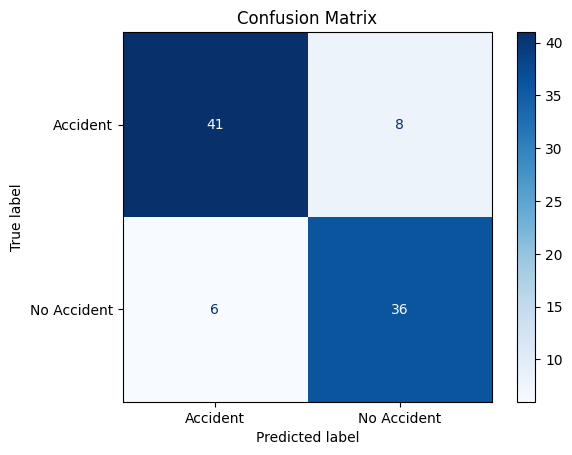

Classification Report:
              precision    recall  f1-score   support

    Accident       0.87      0.84      0.85        49
 No Accident       0.82      0.86      0.84        42

    accuracy                           0.85        91
   macro avg       0.85      0.85      0.85        91
weighted avg       0.85      0.85      0.85        91



In [ ]:

evaluate_model_confusion_matrix(model, test_loader)

###Class: Accident

  Precision (0.87):
  Out of all images predicted as "Accident," 87% were correctly classified.
  Indicates a low rate of false positives for the "Accident" class.

  Recall (0.84):
  Out of all actual "Accident" images, 84% were correctly classified.
  Indicates a small proportion of false negatives for the "Accident" class.

  F1-Score (0.85):
 Combines precision and recall into a single metric.
 A high F1-score reflects a good balance between precision and recall.

  Support (49):
  There are 49 actual "Accident" images in the dataset.

###Class: No Accident

  Precision (0.82):
  Out of all images predicted as "No Accident," 82% were correct.
  Indicates a slightly higher rate of false positives for the "No Accident" class compared to "Accident."

  Recall (0.86):
  Out of all actual "No Accident" images, 86% were correctly classified.
  The model is good at identifying "No Accident" cases.

  F1-Score (0.79):
  Shows a good balance between precision and recall for "No Accident."

  Support (42):
  There are 42 actual "No Accident" images in the dataset.
  Overall Metrics

  Accuracy (0.84):
  The model correctly classified 84% of all images.

###Overall Metrics

  Accuracy (0.85):
  The model correctly classified 85% of all images in the test set.
  This is a strong overall performance, especially for a binary classification problem.

  Macro Average:
  Precision, Recall, and F1-score (0.85):
  A macro average of 0.85 shows balanced performance across classes, which is important in datasets with similar class sizes.

  Weighted Average:
  Precision, Recall, and F1-score (0.85):
  Weighted average accounts for the number of instances (support) in each class.
  With near-equal support for "Accident" and "No Accident," the weighted average aligns closely with the macro average.


###Strengths:
The model performs well in detecting "Accident" images (high recall for "Accident").
Precision for "No Accident" is high, indicating reliable identification when predicting "No Accident."

###Weaknesses:

Lower recall for "No Accident" (71%) suggests the model struggles to correctly identify all "No Accident" images, possibly misclassifying some as "Accident."
This might lead to unnecessary actions (e.g., false alarms for accident cases).
Possible Improvements:


##ROC Curve (Receiver Operating Characteristic Curve)

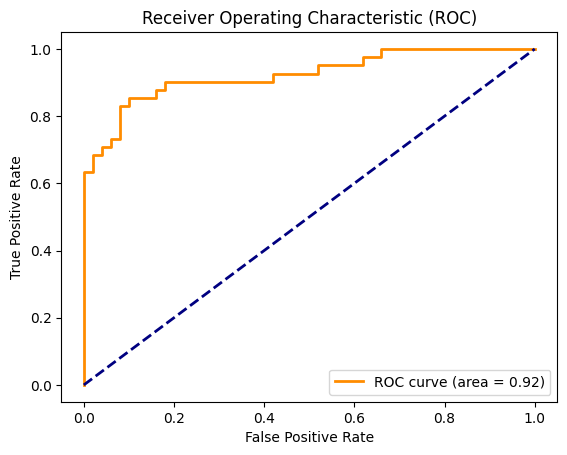

In [ ]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(model, test_loader):
    """
    Plots the ROC curve for the model's predictions.
    """
    model.eval()
    y_true = []
    y_scores = []

    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)  # Get raw scores (logits)
            probs = torch.softmax(outputs, dim=1)[:, 1]  # Probabilities for class 1
            y_true.extend(labels.numpy())
            y_scores.extend(probs.numpy())

    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

# Call the function
plot_roc_curve(model, test_loader)


Closer to the Top-Left Corner:
The model performs better with high TPR and low FPR.

AUC Value = 0.92
An AUC of 0.92 means the model has a 92% chance of correctly distinguishing between a positive and a negative sample.
Indicates the model has excellent separability between Accident and No accident.

##Loss and Accuracy Tracking

In [ ]:
def plot_training_progress(train_losses, val_losses, val_accuracies):
  """
  Plots training and validation loss/accuracy over epochs.

  Args:
  - train_losses: List of training losses per epoch.
  - val_losses: List of validation losses per epoch.
  - val_accuracies: List of validation accuracies per epoch.
  """
  epochs = range(1, len(train_losses) + 1)

  # Plot Loss
  plt.figure(figsize=(10, 5))
  plt.plot(epochs, train_losses, 'r', label='Training Loss')
  plt.plot(epochs, val_losses, 'b', label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

  # Plot Accuracy
  plt.figure(figsize=(10, 5))
  plt.plot(epochs, val_accuracies, 'g', label='Validation Accuracy')
  plt.title('Validation Accuracy Over Epochs')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()


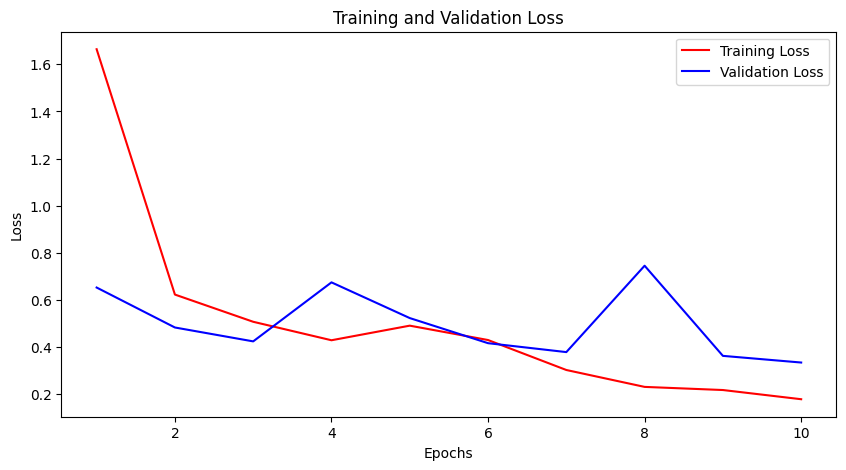

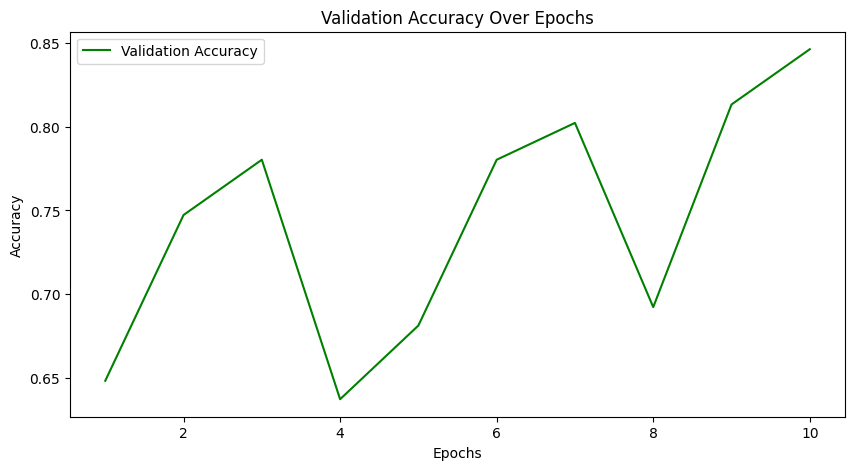

In [ ]:
# Visualize Loss and Accuracy
plot_training_progress(train_losses, val_losses, val_accuracies)

Since the validation loss decreases with the training loss, the model is learning well.

The validation accuracy shows some fluctuations during training it is overally increasing so that it indicated that the model is learning and generalizing well
